In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:

import nltk
#nltk.download()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import re
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

# Data Loading

In [3]:
sms=pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# EDA

In [4]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
sms.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


In [6]:
sms.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [7]:
sms=sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms.isnull().sum()

v1    0
v2    0
dtype: int64

In [8]:
sms=sms.rename({'v1':'label','v2':'text'},axis=1)
sms.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

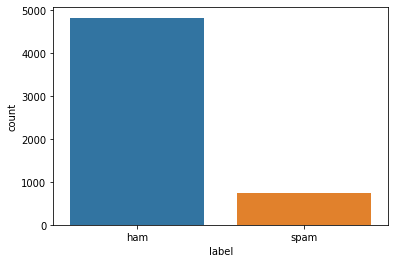

In [9]:
sns.countplot(sms['label'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length', ylabel='Density'>

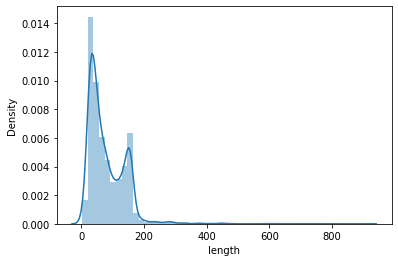

In [10]:
sms['length']=sms['text'].apply(lambda x: len(x))
sns.distplot(sms['length'], kde=True)

<AxesSubplot:xlabel='label', ylabel='length'>

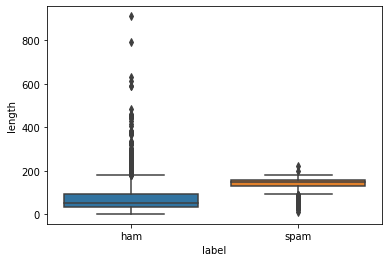

In [11]:
sns.boxplot(y='length', x='label', data=sms)

In [12]:
dt=sms.groupby('label').mean()
#sns.barplot(y='length', x='label', data=dt)
dt

,length
label,
ham,71.021347
spam,138.429719


In [13]:
sms.groupby('label').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.021347  58.014768   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.429719  29.049857  13.0  132.0  149.0  157.0  223.0

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

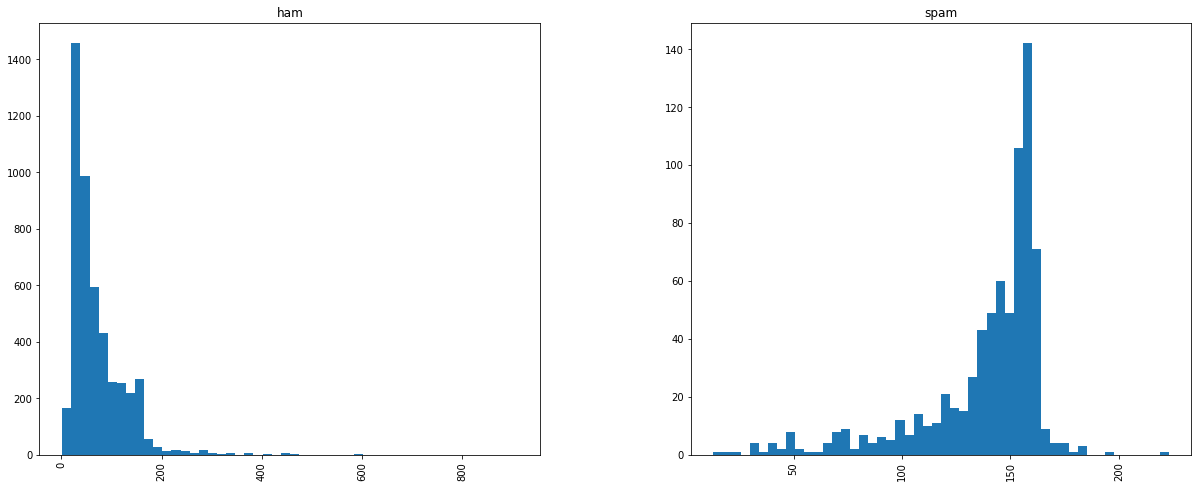

In [14]:
sms.hist(column='length', by='label', bins=50,figsize=(20,8))

# Data Preprocessing

In [15]:
ps=PorterStemmer()
def preprocess(x):
    x = x.lower()
    x = re.sub(r'[^0-9a-zA-Z]', ' ', x)
    x = re.sub(r'\s+', ' ', x)
    l = [item for item in x if item not in string.punctuation]
    processed=[ps.stem(i) for i in l if i not in stopwords.words('english')]
    return processed


In [16]:
X=sms['text']
y=sms['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Pipeline 

In [17]:
def model(model_name,X_train,y_train,X_test,y_test):
    pipeline=Pipeline([
    ('bow', CountVectorizer(analyzer=preprocess)),
    ('tfidf', TfidfTransformer()),
    ('model', model_name),
    ])
    pipeline.fit(X_train,y_train)

    preds=pipeline.predict(X_test)

    print (classification_report(y_test,preds))
    print (confusion_matrix(y_test,preds))
    print('Accuracy:', pipeline.score(X_test, y_test)*100)
    print("Training Score:",pipeline.score(X_train,y_train)*100)
    from sklearn.metrics import accuracy_score
    score = accuracy_score(y_test,preds)
    print(score)


MultinomialNB 

In [18]:
model_name=MultinomialNB()
model(model_name,X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.96      0.99      0.98      1452
        spam       0.95      0.73      0.83       220

    accuracy                           0.96      1672
   macro avg       0.96      0.86      0.90      1672
weighted avg       0.96      0.96      0.96      1672

[[1444    8]
 [  59  161]]
Accuracy: 95.99282296650718
Training Score: 96.38461538461539
0.9599282296650717


RF

In [19]:
model_name=RandomForestClassifier()
model(model_name,X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1452
        spam       0.96      0.88      0.92       220

    accuracy                           0.98      1672
   macro avg       0.97      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672

[[1445    7]
 [  27  193]]
Accuracy: 97.96650717703349
Training Score: 100.0
0.9796650717703349


Gradient Boosting

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
model_name=GradientBoostingClassifier()
model(model_name,X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1452
        spam       0.94      0.89      0.91       220

    accuracy                           0.98      1672
   macro avg       0.96      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672

[[1440   12]
 [  25  195]]
Accuracy: 97.78708133971293
Training Score: 99.53846153846155
0.9778708133971292


XGBoost

In [21]:
model_name=XGBClassifier()
model(model_name,X_train,y_train,X_test,y_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:51:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1452
        spam       0.96      0.89      0.92       220

    accuracy                           0.98      1672
   macro avg       0.97      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672

[[1444    8]
 [  24  196]]
Accuracy: 98.08612440191388
Training Score: 100.0
0.9808612440191388


SVC

In [22]:
model_name=SVC()
model(model_name,X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1452
        spam       0.97      0.82      0.89       220

    accuracy                           0.97      1672
   macro avg       0.97      0.91      0.94      1672
weighted avg       0.97      0.97      0.97      1672

[[1446    6]
 [  40  180]]
Accuracy: 97.24880382775119
Training Score: 97.87179487179488
0.972488038277512
